
# Thresholds

Processes all info files with a certain prefix and plots various values for changing thresholds.

Only considers files that end with `-info.txt`
The info files must have the following format:
ticks: 1
numberOfBrokers: 1
numberOfLeaders: 1
nLeaderJoins: 1
nMemberJoins: 1
nMemberNotifications: 1`
latencyThreshold: 1.0


In [36]:
# imports
import pandas as pd
import seaborn as sns
import os
import glob
# colorbar
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

# vars
dir = "../simulation-result"
prefix = "sim"

# computed vars
dataDir = os.path.abspath(dir)
output = dataDir + "/" + prefix
filenames = [f for f in glob.glob(dataDir + "/" + prefix + "*-info.txt", recursive=True)]

print("{0!s} files found".format(len(filenames)))
print("Writing result to " + output)

# Configure seaborn
sns.set()
print("seaborn configured")   


160 files found
Writing result to /Users/jonathanhasenburg/git/Paper---2020---BroadcastGroups/broadcast-group-simulation/simulation-result/sim
seaborn configured


In [37]:
row_data = []
# read in file contents
for filename in filenames:
    with open(filename) as f:
        lines = f.readlines()
        
    row = {}
    for line in lines:
        line = line.replace("\n", "")
        split = line.split(": ")
        try:
            val = int(split[1])
        except ValueError:
            val = float(split[1])
        row[split[0]] = val
    row_data.append(row)
print("Parsed all files, created {0!s} rows".format(len(row_data)))


Parsed all files, created 160 rows


In [38]:
# create dataframe
df_1 = pd.DataFrame(row_data)
df_1.sort_values(by=["latencyThreshold", "numberOfBrokers"], inplace=True)
df_1.set_index("latencyThreshold", inplace=True)

# safe data
df_1.to_csv(output + ".csv")
df_1.head()

,ticks,numberOfBrokers,numberOfLeaders,nLeaderJoins,nMemberJoins,nMemberNotifications
latencyThreshold,,,,,,
10.0,40,1200,260,1070,868,998
10.0,48,2400,337,2493,2555,2985
10.0,55,3600,369,3763,4565,5097
10.0,65,4800,399,5716,7682,8997
10.0,63,6000,403,6823,9311,10537


Median join ration is 1.0407351297911414


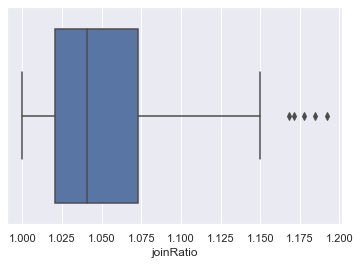

In [39]:
# calculate how many notification messages are send per member join
df_1["joinRatio"] = df_1["nMemberNotifications"] / df_1["nMemberJoins"]
print("Median join ration is " + str(df_1["joinRatio"].median()))
ax = sns.boxplot(x=df_1["joinRatio"])


Transform input data into wide format -> easier to use with seaborn


In [40]:
# move message types into own rows, and add type info
new_row_data = []
types = ["nLeaderJoins", "nMemberJoins", "nMemberNotifications"]
typeNames = {
    "nLeaderJoins": "Leader Joins",
    "nMemberJoins": "Member Joins",
    "nMemberNotifications": "member notifications"
}
for old_row in row_data:
    for type in types:
        row = {
            "Latency Threshold [ms]": old_row["latencyThreshold"],
            "ticks": old_row["ticks"],
            "Number of Brokers": old_row["numberOfBrokers"],
            "number of leaders": old_row["numberOfLeaders"],
            "Quantity": old_row[type],
            "operation type": typeNames[type]
        }
        new_row_data.append(row)
        
print("Moved message types into separate rows, went from {0!s} to {1!s} rows".format(len(row_data), len(new_row_data)))


Moved message types into separate rows, went from 160 to 480 rows


In [41]:
df = pd.DataFrame(new_row_data)
df.head()

,Latency Threshold [ms],ticks,Number of Brokers,number of leaders,Quantity,operation type
0,70.0,100,9600,22,11325,Leader Joins
1,70.0,100,9600,22,37612,Member Joins
2,70.0,100,9600,22,39359,member notifications
3,50.0,60,2400,35,2837,Leader Joins
4,50.0,60,2400,35,6218,Member Joins


# Number of Leaders

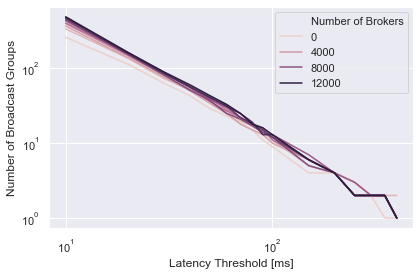

In [42]:
tmp = df
tmp["Number of Broadcast Groups"] = tmp["number of leaders"]
ax = sns.lineplot(data=tmp, x="Latency Threshold [ms]", y="Number of Broadcast Groups", hue="Number of Brokers")
ax.set(xscale="log", yscale="log")
fig = ax.get_figure()
fig.tight_layout()    

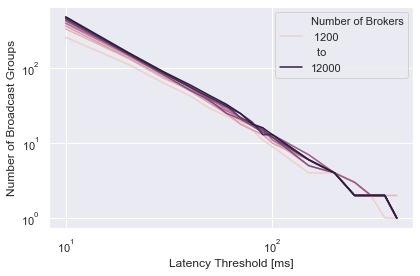

In [43]:
handles, labels = ax.get_legend_handles_labels()
new_labels = ["Number of Brokers", " 1200", "  to", "12000"]
new_handles = [handles[0], handles[1], handles[0], handles[-1]]
ax.legend(new_handles, new_labels)
ax.get_figure()

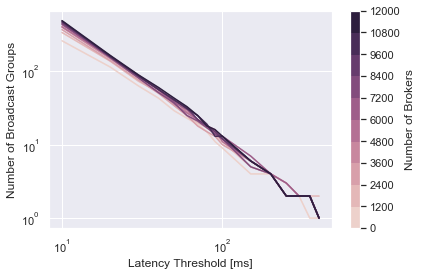

In [44]:
# use a colorbar instead of legend
current_palette = sns.cubehelix_palette(n_colors=10)
cmap = ListedColormap(sns.color_palette(current_palette).as_hex())

norm = plt.Normalize(0, 12000)
ticks = [0, 1200, 2400, 3600, 4800, 6000, 7200, 8400, 9600, 10800, 12000]
colorbar = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
ax.get_legend().remove()
ax.figure.colorbar(colorbar, ticks=ticks).set_label("Number of Brokers")
fig = ax.get_figure()
fig.tight_layout()
fig.savefig(output + "-leaders.pdf")
fig

# Number of Ticks

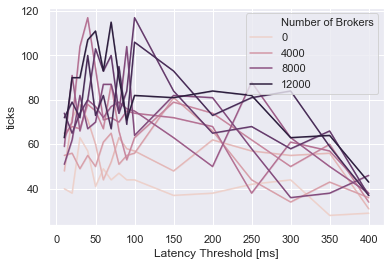

In [45]:
tmp = df
ax = sns.lineplot(data=tmp, x="Latency Threshold [ms]", y="ticks", hue="Number of Brokers")

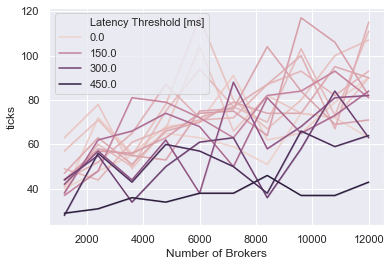

In [46]:
tmp = df
ax = sns.lineplot(data=tmp, x="Number of Brokers", y="ticks", hue="Latency Threshold [ms]")

# Number of Operations

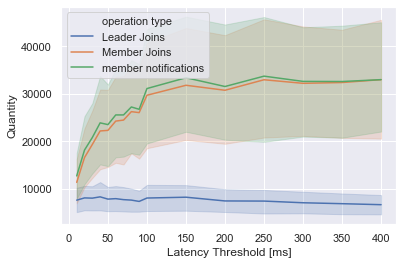

In [47]:
# the error bars are based on broker numbers
tmp = df
ax = sns.lineplot(data=tmp, x="Latency Threshold [ms]", y="Quantity", hue="operation type")


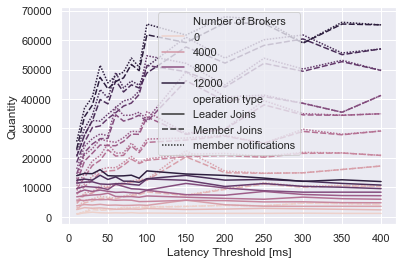

In [48]:
tmp = df
ax = sns.lineplot(data=tmp, x="Latency Threshold [ms]", y="Quantity", style="operation type", hue="Number of Brokers")


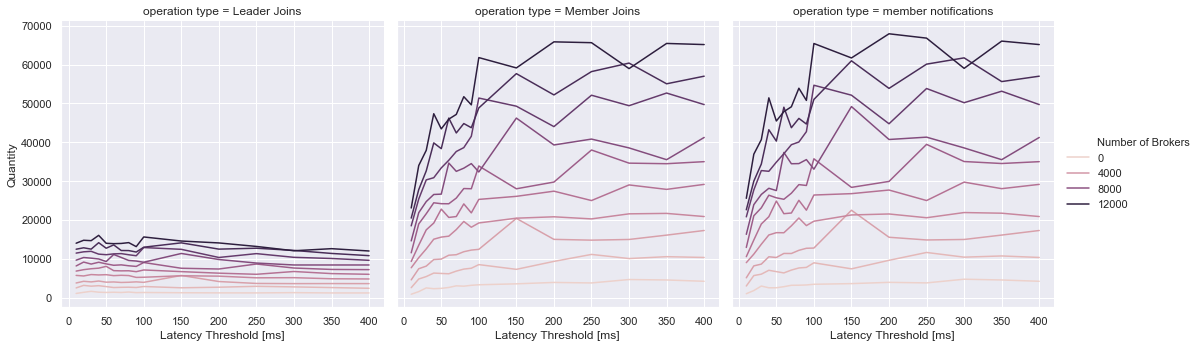

In [49]:
tmp = df
ax = sns.relplot(data=tmp, kind="line", x="Latency Threshold [ms]", y="Quantity", hue="Number of Brokers", col="operation type")

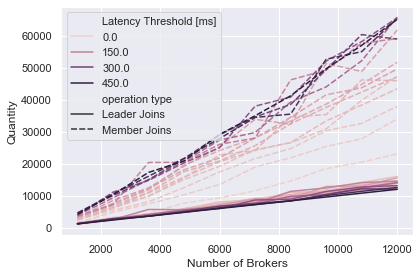

In [50]:
tmp = df[df["operation type"] != "member notifications"]
ax = sns.lineplot(data=tmp, x="Number of Brokers", y="Quantity", style="operation type", hue="Latency Threshold [ms]")
fig = ax.get_figure()
fig.tight_layout() 

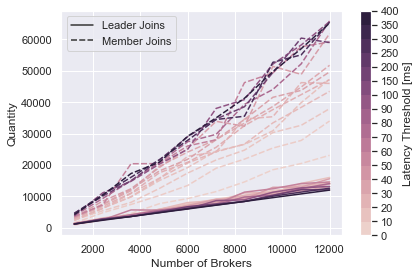

In [51]:
# use colorbar for Latency Threshold (16 values)
current_palette = sns.cubehelix_palette(n_colors=16)
cmap = ListedColormap(sns.color_palette(current_palette).as_hex())

norm = plt.Normalize(0, 16)
ticks = range(17)
tick_labels = ["0", "10", "20", "30", "40", "50", "60", "70", "80", "90", "100", "150", "200", "250", "300", "350", 
              "400"]

# clean old legend
handles, labels = ax.get_legend_handles_labels()
new_labels = [labels[6], labels[7]]
new_handles = [handles[6], handles[7]]
ax.legend(new_handles, new_labels)

# colorbar
colorbar = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
cb_ax = ax.figure.colorbar(colorbar, ticks=ticks)
cb_ax.set_label("Latency Threshold [ms]")
cb_ax.set_ticklabels(tick_labels)
fig = ax.get_figure()
fig.tight_layout()
fig.savefig(output + "-operations.pdf")
fig


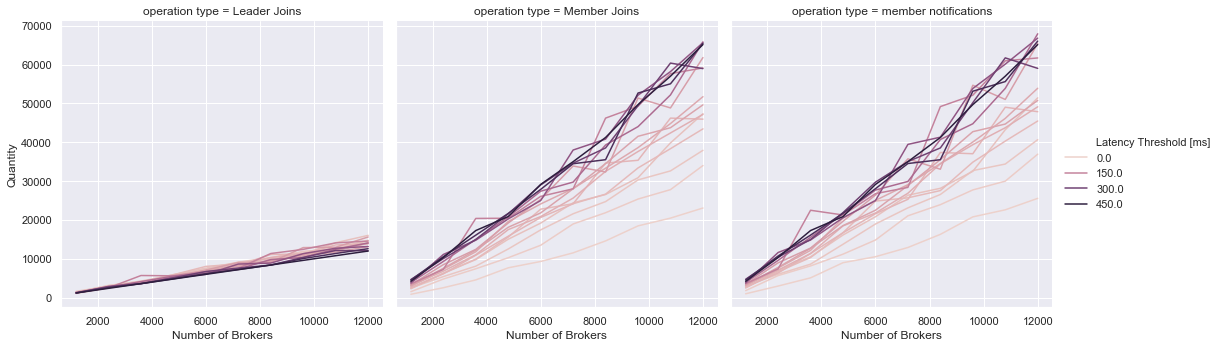

In [52]:
tmp = df
ax = sns.relplot(data=tmp, kind="line", x="Number of Brokers", y="Quantity", hue="Latency Threshold [ms]", col="operation type")

/anaconda3/envs/visualization/lib/python3.7/site-packages/pandas/core/frame.py:4238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)


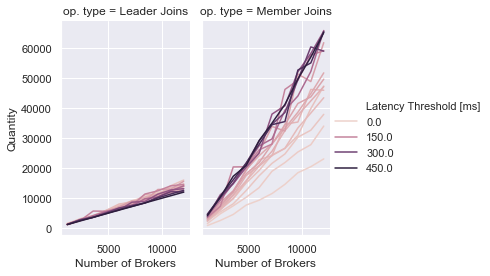

In [53]:
# influence of Number of Brokers on member and leader joins
tmp = df[df["operation type"] != "member notifications"]
tmp.rename(columns = {"operation type": "op. type"}, inplace=True)
fig = sns.relplot(data=tmp, kind="line", 
                  x="Number of Brokers", y="Quantity", hue="Latency Threshold [ms]", col="op. type", aspect=0.64, 
                  height=4)
# fig.tight_layout()    
# fig.savefig(output + "-operations.pdf")
# For the median number of joins per member notification, see boxplot above